In [98]:
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import io
import time
import seaborn as sns
# from sklearn.datasets.samples_generator import make_blobs
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder, Imputer, OneHotEncoder, StandardScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split #membagi data jadi train dan test
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import LinearRegression

In [99]:
col = ["price","condition", "odometer","year"]
df = pd.read_csv('used_cars.csv', usecols=col)

In [100]:
def preprocess(df):    
    #drop outlier
    df.price =df.price.replace(1172420096, np.nan)
    df.price =df.price.replace(123456789, np.nan)

    #cek missing values
    print("cek jumlah missing values",df.isnull().sum())
    print('')
    #DATA CLEANSING

    # fill missing values dengan median odometer values https://machinelearningmastery.com/handle-missing-data-python/
    df.odometer.fillna(df.odometer.median(), inplace=True)
    df.year.fillna(df.year.median(), inplace=True)

    #drop missing values di categorical
    df = df.dropna()
    # print(df.price.describe())
    #visual outlier
    plt.figure(figsize=(3,6))
    sns.boxplot(y='price', data=df,showfliers=False);
    sns.boxplot(y='price', data=df);
    sns.violinplot(y='price', data=df);
    
    #price replace numerical to categorical 
    df.price = df.price.replace(range(0,5000), 'cheap', regex=True)
    df.price = df.price.replace(range(5000,10000), 'mid', regex=True)
    df.price = df.price.replace(range(10000,140000), 'expensive', regex=True)
    
    #    Cek balance
    con = df.groupby('price')
    print(con.count())

    #encode fitur

    encoded = pd.get_dummies(df['condition'])
    df = df.join(encoded).drop('condition', axis=1)
    X = df
    X.price.fillna(0, inplace=True)
    
   
    return df



('cek jumlah missing values', price           2
year           12
condition    9152
odometer     2389
dtype: int64)

           year  condition  odometer
price                               
cheap      3224       3224      3224
expensive  4440       4440      4440
mid        3184       3184      3184


0

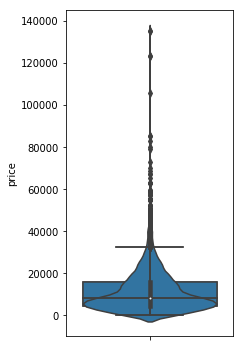

In [101]:
df = preprocess(df)
#encode label
le = LabelEncoder()
df.price = pd.Series(le.fit_transform(df.price), name = 'price')
Y = df.price
df.price.fillna(0, inplace=True)
Y.isnull().sum()


In [102]:
#Inisialisasi fitur dam label
# print(df)
X = df
Y = df.price

              price      year  odometer  excellent      fair      good  \
price      1.000000  0.013665  0.001842   0.080086 -0.018619 -0.075560   
year       0.013665  1.000000 -0.253112   0.103753 -0.237792 -0.054364   
odometer   0.001842 -0.253112  1.000000  -0.003168  0.102625  0.019343   
excellent  0.080086  0.103753 -0.003168   1.000000 -0.193906 -0.813914   
fair      -0.018619 -0.237792  0.102625  -0.193906  1.000000 -0.146977   
good      -0.075560 -0.054364  0.019343  -0.813914 -0.146977  1.000000   
like new   0.000373  0.083685 -0.106780  -0.266291 -0.048087 -0.201844   
new       -0.009557  0.000577 -0.029731  -0.050792 -0.009172 -0.038499   
salvage    0.008637 -0.053086  0.016591  -0.051762 -0.009347 -0.039234   

           like new       new   salvage  
price      0.000373 -0.009557  0.008637  
year       0.083685  0.000577 -0.053086  
odometer  -0.106780 -0.029731  0.016591  
excellent -0.266291 -0.050792 -0.051762  
fair      -0.048087 -0.009172 -0.009347  
good   

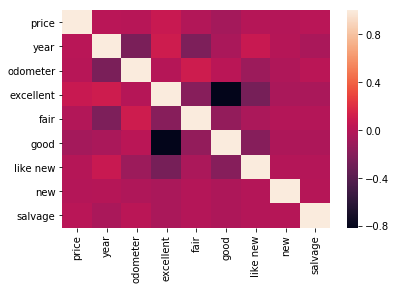

In [103]:
#korelasi price dengan fitur lain
ax = sns.heatmap(df.corr())
print(df.corr())

In [104]:
#normalisasi: changing the shape of the distribution of your data
def norm(X):
    norm = Normalizer()
    norm.fit(X)
    X = pd.DataFrame(norm.transform(X))
    return X

In [105]:
#SCALING: changing the range of your data

# Use StandardScaler if you know the data distribution is normal.
def scalin(X):
    scaler = StandardScaler()
    scaler.fit(X)
    X = pd.DataFrame(scaler.transform(X))
    return X # range about the mean 0 and standard deviation 1

# Use this as the first scaler choice to transform a feature, as it will preserve the shape of the dataset (no distortion).
def minmaxScale(X):
    X = pd.DataFrame(MinMaxScaler().fit_transform(X))
    return X # range 0 hingga 1. 


In [106]:
#CLUSTER KMEANS
def cluster(X):
    ##mereduksi dimensi dgn PCA
    pca = PCA(n_components=2)
    principalCom = pca.fit_transform(X)
    principalDf = pd.DataFrame(data = principalCom, columns = ['principal component 1', 'principal component 2'])
    principalDf.head()
    sns.scatterplot(x=principalDf['principal component 1'], y =principalDf['principal component 2'])
    X = principalDf.copy().values
    m= X.shape[0] #number of training examples
    n= X.shape[1] #number of features/dimensi n=2
    iteration= 100
    K=5 # number of clusters
    n
    Centroids=np.array([]).reshape(n,0) 
    for i in range(K):
        rand=np.random.randint(0,m-1)
        Centroids=np.c_[Centroids,X[rand]]
    Output={}
    for i in range(iteration):
        EuclidianDistance=np.array([]).reshape(m,0)
        for k in range(K):
            tempDist=np.sum((X-Centroids[:,k])**2,axis=1)
            EuclidianDistance=np.c_[EuclidianDistance,tempDist]
        C=np.argmin(EuclidianDistance,axis=1)+1

        Y={}
        for k in range(K):
            Y[k+1]=np.array([]).reshape(2,0)
        for i in range(m):
            Y[C[i]]=np.c_[Y[C[i]],X[i]]

        for k in range(K):
            Y[k+1]=Y[k+1].T

        for k in range(K):
            Centroids[:,k]=np.mean(Y[k+1],axis=0)
        Output=Y
   
    #plot
    plt.scatter(X[:,0],X[:,1],c='black',label='unclustered data')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=2)
    plt.title('Plot of data points')
    plt.show()
    color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
    labels=['cluster1','cluster2','cluster3','cluster4','cluster5']
    for k in range(K):
        plt.scatter(Output[k+1][:,0],Output[k+1][:,1],c=color[k],label=labels[k])
    plt.scatter(Centroids[0,:],Centroids[1,:],marker='+',s=100,c='black',label='Centroids')
    plt.xlabel('Y')
    plt.ylabel('X')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=2)

    plt.show()


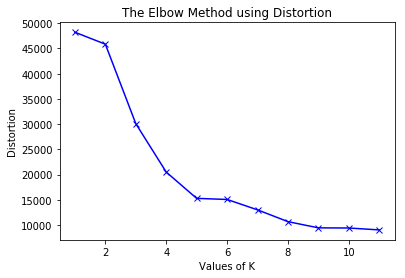

In [107]:
### EVALUASI KMEANS dgn Elbow Method
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist 

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,12) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_
    



plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

#

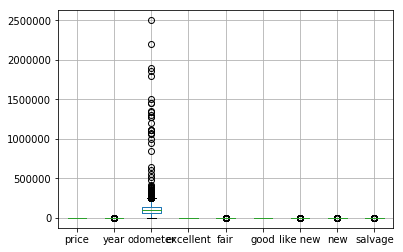

In [108]:
#before scale/normalize
X.boxplot()

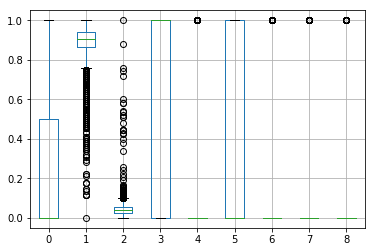

In [109]:
#pilih satu
# X = scalin(X)
X = minmaxScale(X)
# X = norm(X)
X.boxplot()

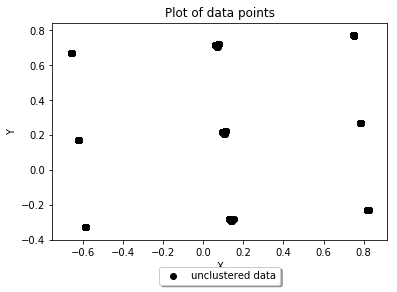

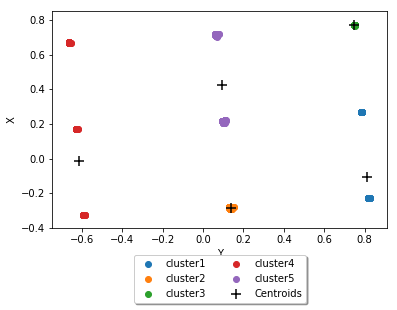

In [110]:
cluster(X)

KLASIFIKASI

In [111]:
def clfKNN(xTrain,xTest,yTrain,yTest):

    #K-NN

    clf = KNeighborsClassifier(n_neighbors = rd.randint(1,5))
    clf.fit(xTrain, yTrain)
    yPred = clf.predict(xTest)
    ak = accuracy_score(yTest,yPred)*100
    print('akurasi = ',ak)
    error_rate = []
    for i in range(1,6):
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(xTrain,yTrain)
        pred_i = knn.predict(xTest)
        ak = accuracy_score(yTest,pred_i)*100
#         print('i-',i,' ',ak)
        error_rate.append(np.mean(pred_i != yTest))
    errorRate(error_rate)
def errorRate(error_rate):
    plt.show()
    print('')
    plt.plot(range(1,6), error_rate, color= 'blue', linestyle='dashed', marker= 'o', markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs K')
    plt.xlabel('K')
    plt.ylabel('Error Rate')
    plt.show()
def visKNN(datasets):
    import pylab as pl
    iris = datasets.load_iris()
    X = iris.data[:, :2] # we only take the first two features. 
    Y = iris.target


    h = .02 # step size in the mesh

    knn=neighbors.KNeighborsClassifier()

    # we create an instance of Neighbours Classifier and fit the data.
    knn.fit(X, Y)

    # Plot the decision boundary. For that, we will asign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = X[:,0].min() - .5, X[:,0].max() + .5
    y_min, y_max = X[:,1].min() - .5, X[:,1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    pl.figure(1, figsize=(4, 3))
    pl.set_cmap(pl.cm.Paired)
    pl.pcolormesh(xx, yy, Z)

    # Plot also the training points
    pl.scatter(X[:,0], X[:,1],c=Y )
    pl.xlabel('Sepal length')
    pl.ylabel('Sepal width')

    pl.xlim(xx.min(), xx.max())
    pl.ylim(yy.min(), yy.max())
    pl.xticks(())
    pl.yticks(())

    pl.show()
def evaluasi(xTrain,xTest,yTrain,yTest):
    clf = KNeighborsClassifier(n_neighbors = 1)#, p =2, weight = 'uniform')
    clf.fit(xTrain, yTrain)
    yPred = clf.predict(xTest)
    #cek apakah overfitting jika train>test
    linreg = LinearRegression()
    linreg.fit(xTrain,yTrain)
    train = linreg.score(xTrain, yTrain)
    test = linreg.score(xTest, yTest)
    if train>test:
        print('OVERFIT!')

    #evaluasi pake confusion matrix
    pred = clf.predict(xTest)
#     print(confusion_matrix(yTest,pred))
    target_name = ['class 0', 'class 1', 'class 2']
    print('')
    print(classification_report(yTest, pred))
    
# def vKNN()

In [112]:
import warnings

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

('akurasi = ', 99.88826815642457)



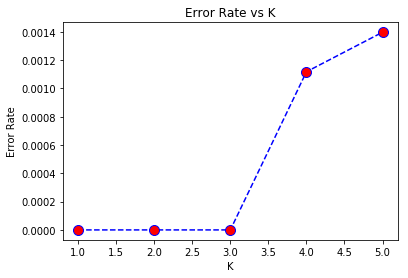

--- 0.583999872208 seconds ---

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      2121
        1.0       1.00      1.00      1.00       860
        2.0       1.00      1.00      1.00       599

avg / total       1.00      1.00      1.00      3580



In [113]:
xTrain, xTest, yTrain, yTest = train_test_split(X,Y, test_size = 0.33, random_state=42)
start_time = time.time()
clfKNN(xTrain,xTest,yTrain,yTest)
print("--- %s seconds ---" % (time.time() - start_time))
evaluasi(xTrain,xTest,yTrain,yTest)

     F1 SCORE
('cheap', 0.9990579368817711)
('expensive', 0.9976689976689977)
('mid', 1.0)
('macro avg', 0.9989089781835897)


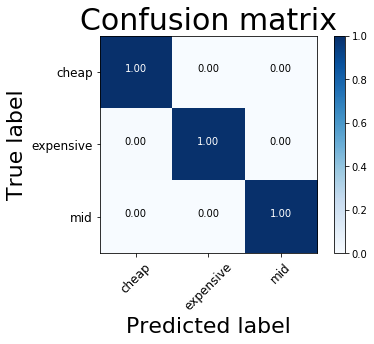

In [114]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import itertools
from sklearn import preprocessing

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=22)
    plt.xlabel('Predicted label', fontsize=22)
clf = KNeighborsClassifier(n_neighbors = rd.randint(1,5))
clf.fit(xTrain, yTrain)
yPred = clf.predict(xTest)
res = f1_score(yTest, yPred, average=None)
print('     F1 SCORE')
for i in range(len(res)):
    print(le.classes_[i], res[i])
print('macro avg', f1_score(yTest, yPred, average='macro'))    
plot_confusion_matrix(confusion_matrix(yTest,yPred),le.classes_)

In [115]:
#simpan data yang telah diolah
df.to_csv('used_car(explored).csv')